## Installing and Importing Libraries

In [1]:
%pip install opencv-python tensorflow matplotlib numpy pandas

In [2]:
import tensorflow as tf
import os
import cv2 
import matplotlib.pyplot as plt
import numpy as np

2024-08-01 17:15:03.474323: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data Preparation

In [3]:
data_dir = 'data'
image_exts = ['jpg', 'jpeg', 'png', 'bmp', 'gif']

In [4]:
try:
    os.remove(os.path.join(data_dir, '.DS_Store'))
except:
    pass

In [5]:
for image_class in os.listdir(data_dir): 
    print(image_class)
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        file_size = os.stat(image_path).st_size / 1000
        try: 
            if file_size < 5:
                os.remove(image_path)
                continue
            img = cv2.imread(image_path)
            tip = image_path.split('.')[-1]
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            os.remove(image_path)

happy
sad


In [6]:
tf.keras.utils.image_dataset_from_directory??

Signature:
tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format=None,
    verbose=True,
)
Source:   
@keras_export(
    [
        "keras.utils.image_dataset_from_directory",
        "keras.preprocessing.image_dataset_from_directory",
    ]
)
def image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format=None,
    ve

In [7]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 225 files belonging to 2 classes.


In [8]:
data_iterator = data.as_numpy_iterator()

In [9]:
batch = data_iterator.next()

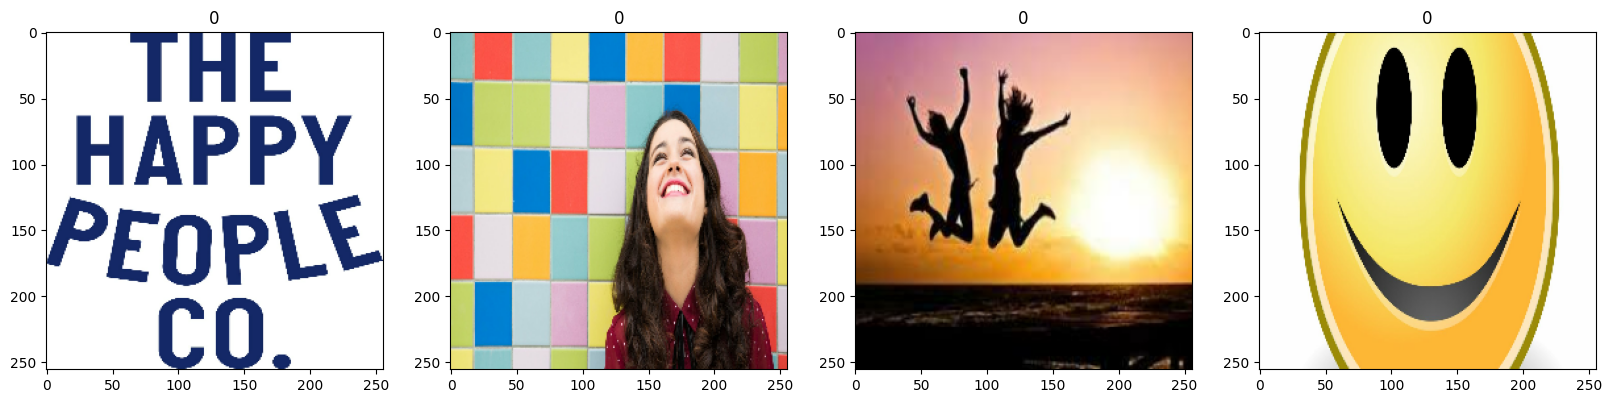

In [10]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [11]:
data = data.map(lambda x,y: (x/255, y)) # Normalize the data, easier for the model to learn

## Crearting the Train, Validation, and Test Batches

In [12]:
len(data) # 8 * 32 = 256

8

In [13]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2) + 1
test_size = int(len(data)*.1) + 1

In [14]:
test_size + val_size + train_size # making sure we have all the data

8

In [15]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [16]:
test

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

## Building the Model

In [17]:
from tensorflow.keras.models import Sequential # there are two types of models in keras, sequential and functional
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Input # layers we will use in our model

In [18]:
model = Sequential()

In [19]:
model.add(Input(shape=(256,256,3)))
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D()) # default pool size is 2x2, it will reduce the size of the image by half

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten()) # flatten the data to feed it to the dense layer

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [20]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy']) # compile the model with the optimizer, loss function and metrics

In [21]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
logdir='logs'

In [23]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir) # tensorboard callback to log the data


## Training the Model

In [24]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 952ms/step - accuracy: 0.4742 - loss: 1.0042 - val_accuracy: 0.6406 - val_loss: 0.6702
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 929ms/step - accuracy: 0.5663 - loss: 0.6612 - val_accuracy: 0.5469 - val_loss: 0.6119
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6273 - loss: 0.5504 - val_accuracy: 0.7188 - val_loss: 0.4653
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7732 - loss: 0.4520 - val_accuracy: 0.8281 - val_loss: 0.4538
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 957ms/step - accuracy: 0.7831 - loss: 0.4597 - val_accuracy: 0.6719 - val_loss: 0.4566
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7915 - loss: 0.3489 - val_accuracy: 0.9531 - val_loss: 0.3333
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8622 - loss: 0.3810 - val_accuracy: 0.9062 - val_loss: 0.3145
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9327 - loss: 0.2835 - val_accuracy: 0.9219 - val_loss: 0.2215
Epoch 9

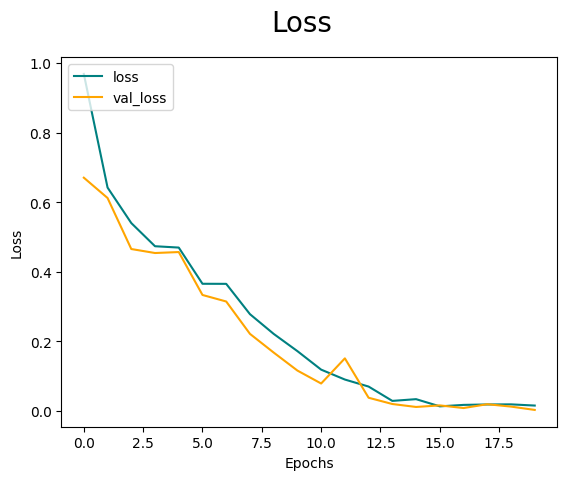

In [25]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper left")
plt.show()

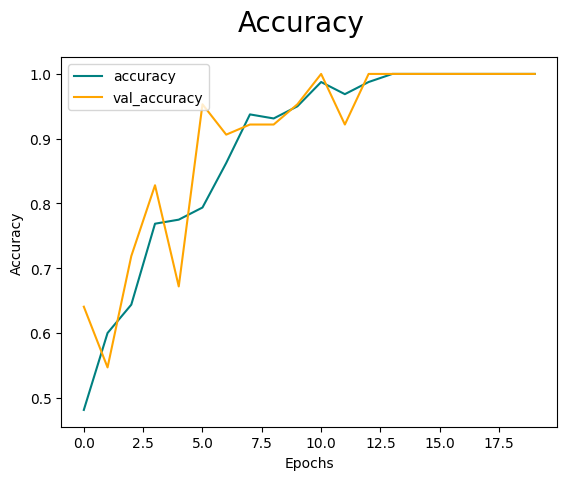

In [26]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc="upper left")
plt.show()

In [27]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [28]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

## Testing the Model

In [29]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


2024-08-01 17:16:56.492607: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [30]:
print(f'Percision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')


Percision: 0.0, Recall: 0.0, Accuracy: 1.0


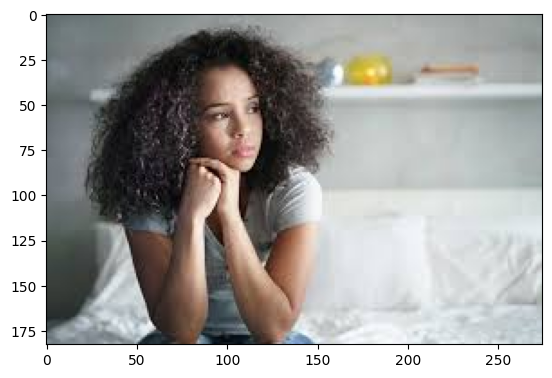

In [31]:
img = cv2.imread('sad.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

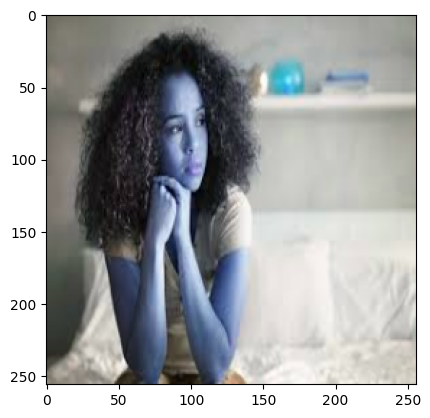

In [32]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))

plt.show()

In [33]:
np.expand_dims(resize, axis=0).shape

(1, 256, 256, 3)

In [34]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [35]:
yhat

array([[0.89553934]], dtype=float32)

In [36]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad


## Saving the Model

In [37]:
from tensorflow.keras.models import load_model

In [38]:
model.save(os.path.join('models','happysadmodel.keras'))


In [39]:
loaded_model = load_model(os.path.join('models','happysadmodel.keras'))


In [40]:
loaded_model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


array([[0.89553934]], dtype=float32)